<p align="center">
<h1>Signals and systems</h1>
<h2>Project documentation</h2>
Author: Denis Dzíbela xdzibe00
</p>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, fft, signal
from scipy.io import wavfile

## Input preprocessing

### File input

Sampling rate: 16000Hz
Audio length:
               53556 samples
               3.34725 seconds
Max value:     2635
Min value:     -1516


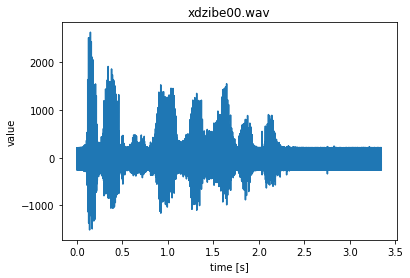

In [26]:
samplingRate, rawData = io.wavfile.read('../audio/xdzibe00.wav')
#Get info about our signal
print('Sampling rate: ' + str(samplingRate) + 'Hz')
print('Audio length:')
print('               ' + str(rawData.size) + ' samples')
print('               ' + str(rawData.size / samplingRate) + ' seconds')
print('Max value:     ' + str(rawData.max()))
print('Min value:     ' + str(rawData.min()))
#Plotting our signal
plt.figure(1)
plt.title('xdzibe00.wav')
plt.xlabel('time [s]')
plt.ylabel('value')
Time = np.linspace(0, len(rawData) / samplingRate, num=len(rawData))
plt.plot(Time, rawData)
plt.show()

### Normalization and segmentation

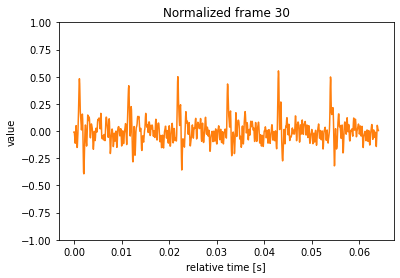

In [27]:
#remove DC bias
rawData -= int(np.mean(rawData))
#normalize the data
normData = rawData / np.abs(rawData).max()

#slice into 1024 sample long frames, with 512 sample overlap
slicedData = np.zeros(shape=(int(normData.size / 512),1024))
for i in range(0, int(normData.size / 512) - 1): #the last frame would be incomplete so we ignore it
    slicedData[i] = normData[i * 512:(i * 512) + 1024]

#Plot a selected frame
plt.plot(2)
plt.title('Normalized frame 30')
plt.xlabel('relative time [s]')
plt.ylabel('value')
plt.ylim(-1, +1)
Time = np.linspace(0, slicedData[31].size / samplingRate, num=slicedData[31].size)
plt.plot(Time, slicedData[31])
plt.show()

## Fourier transform


### Custom implementation

In [28]:
def customDFT(signal):
    dftMatrix = None
    return dftMatrix * signal

In [29]:
#now we can feed the function with our signal

### Comparison with a library implementation

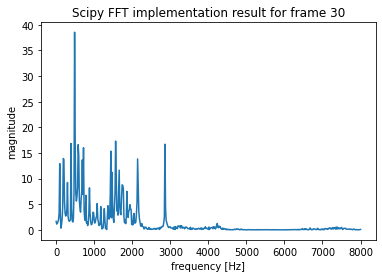

In [30]:
#or just use a library implementation
dftLibrary = np.zeros(shape=(slicedData.shape))
for i in range(0, dftLibrary.shape[0]):
    dftLibrary[i] = np.abs(fft.fft(slicedData[i]))
#
plt.figure(4)
f = np.arange(dftLibrary[30].size) / 1024 * samplingRate
# zobrazujeme prvni pulku spektra
plt.title('Scipy FFT implementation result for frame 30')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
plt.plot(f[:f.size//2+1], dftLibrary[30][:dftLibrary[30].size//2+1])
plt.show()

## Spectrum analysis

### Spectogram

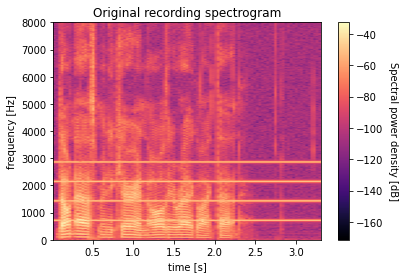

In [31]:
plt.figure(5)
plt.title('Original recording spectrogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(normData, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)

### Rogue signal generation

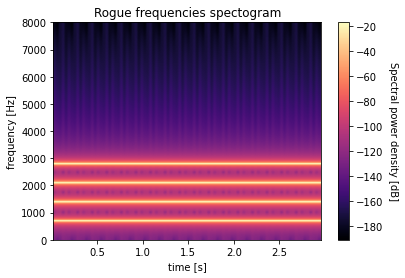

In [32]:
#create a 0 valued signal 3 seconds long
rogueCosines = np.zeros(3 * samplingRate)
#add the rogue frequencies
n = np.linspace(0, 3, 3 * samplingRate, False)
rogueCosines += np.cos(2 * np.pi * 700 * n)
rogueCosines += np.cos(2 * np.pi * 1400 * n)
rogueCosines += np.cos(2 * np.pi * 2100 * n)
rogueCosines += np.cos(2 * np.pi * 2800 * n)
#write the result to file
io.wavfile.write('../audio/4cos.wav', samplingRate, rogueCosines)
#and plot the spectrum
plt.figure(6)
plt.title('Rogue frequencies spectogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(rogueCosines, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)

Now we get the spectrogram of our generated signal and compare it with our original spectrogram

## Filtration

### Filter design

Filter design was chosen as 4 Butterworth bandstop filters centered on the 4 rogue frequencies. 

In [38]:
sos = [0,0,0,0]

#Get Butterworth filter order
ord, wn = signal.buttord(wp=[0.1, 0.6], ws=[0.2, 0.5], gpass=3, gstop=40, fs=samplingRate)

#Construct our four filters, some hand tweaking of the frequency bands was needed
sos[0] = signal.butter(ord, [700 - 55, 700 + 55], 'bandstop', fs=samplingRate, output='sos')
sos[1] = signal.butter(ord, [1400 -55, 1400 +55], 'bandstop', fs=samplingRate, output='sos')
sos[2] = signal.butter(ord, [2100 -75, 2100 +70], 'bandstop', fs=samplingRate, output='sos')
sos[3] = signal.butter(ord, [2800 -75, 2800 +90], 'bandstop', fs=samplingRate, output='sos')

### Zeroes and poles

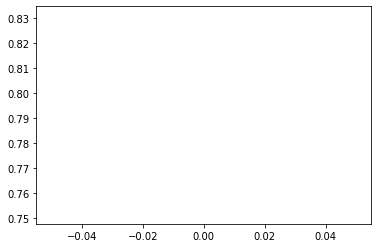

In [34]:
z, p, k = signal.sos2zpk(sos[0])
plt.plot(k)
plt.show()

### Frequency characteristic

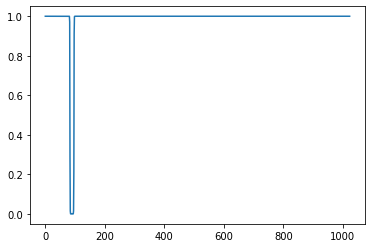

In [35]:
w, h = signal.sosfreqz(sos[0], worN=1024, fs=samplingRate)
plt.plot(np.abs(h))
plt.show()

### Filtration

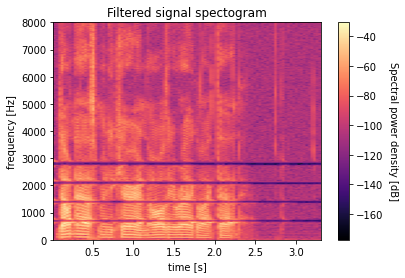

In [36]:
#Apply our four filters
filtered = signal.sosfilt(sos[0], normData)
for i in range(1,3):
    filtered = signal.sosfilt(sos[i], filtered)

#Save the result to file
io.wavfile.write('../audio/clean_bandstop.wav', samplingRate, filtered)

#Plot a spectrogram for good measure
plt.figure(7)
plt.title('Filtered signal spectogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(filtered, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)